<a href="https://colab.research.google.com/github/Colley-K/rock_climbing_recommendation_system/blob/master/rec_system_8a_nu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up & Installs

In [1]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area

#access the OS system to work with current directories:
import os 
os.getcwd() 


Thu Jul 11 15:52:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

'/content'

In [2]:
#importing functions for this notebook
from google.colab import files
uploaded = files.upload()

Saving function.py to function (1).py


In [3]:
#importing cold start threhold functions for this notebook
from google.colab import files
uploaded = files.upload()

Saving cold_start_thresholds.py to cold_start_thresholds.py


### To view in detail all the functions created for this notebook click [here for function.py](https://drive.google.com/open?id=1L7rLB1dvJhZcM2d5vkQ2rovsCQsP-pSM) and [here for cold_start_thresholds.py](https://drive.google.com/open?id=1D4Hbkaqni_zsx5ih_bn7isStV0YhVheH)

In [4]:
#Installs
!pip install surprise

#imports
import cold_start_thresholds as ct
import function as f
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import base64
from collections import defaultdict
import surprise as sp
from surprise.model_selection import cross_validate
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [0]:
#reconfigure default plot settings
pd.set_option('display.max_columns', 10)
sns.set_palette(sns.color_palette("hls", 8))
matplotlib.rc('figure', figsize = (12, 7))
matplotlib.rc('font', size = 14)
matplotlib.rc('axes.spines', top = False, right = False)
matplotlib.rc('axes', grid = False)
matplotlib.rc('axes', facecolor = 'white')

##Importing CSV files:


*   I will import 4 different files from my clean-up report:
* Dataframes that filtered out routes occuring less than 10x, 6x, 3x, 2x
* I will use these four variations to test out the accuracy of the different algoirthms 




In [0]:
#Turn the CSV files into data frames
ascent_1x = pd.read_csv('drive/My Drive/Capstone/data/ascent_1x.csv', low_memory=False) #df that filtered out routes occuring less than 2 times (least filtered df_)
rock_df10 = pd.read_csv('drive/My Drive/Capstone/data/rock_df.csv', low_memory=False) #df that filtered out routes occuring less than ten times
rock_df3 = pd.read_csv('drive/My Drive/Capstone/data/rock_df3.csv', low_memory=False) #df that filtered out routes occuring less than 3 times
rock_df6 = pd.read_csv('drive/My Drive/Capstone/data/rock_df2.csv', low_memory=False)  #df that filtered out routes occuring less than 6 times)
rock6x = pd.read_csv('drive/My Drive/Capstone/data/rock6x.csv', low_memory=False)  #refined df that filtered out routes occuring less than 6 times

In [0]:
ascent_1x ["route"]= ascent_1x["name_id"]

#Matrix size & shapes using different filters


*   How large are the different dataframes?
*   How large are the matrixes, and how sparse are they?
* Findings:
 >* You can see the 3x name filter is an order of magnitute less dense than the other two filters. This could make it more difficult to derive accurate predictions.
 >* The 10x name filter has roughly half the amount of routes as the 6x filter. This could also make the predictions less accurate because it has less data to train on
 >* The **6x route name** filter has the best results, but we will see how it looks in the EDA & the prediction models
 


In [8]:
#Old ascent table density
f.matrix_density(ascent_1x)



Num of unique routes: 182132
Num of unique users: 25801
Matrix size: 4699187732
Shape of df: (1733355, 5)
Density of matrix: 0.00036886268411802196


In [9]:
#3x route name filter
f.matrix_density(rock_df3)


Num of unique routes: 38200
Num of unique users: 21647
Matrix size: 826915400
Shape of df: (557345, 8)
Density of matrix: 0.0006740048619242066


In [10]:
#6x route name filter
f.matrix_density(rock6x)


Num of unique routes: 14995
Num of unique users: 17878
Matrix size: 268080610
Shape of df: (334748, 10)
Density of matrix: 0.0012486841178106839


In [11]:
#10x route name filter
f.matrix_density(rock_df10)

Num of unique routes: 13124
Num of unique users: 20552
Matrix size: 269724448
Shape of df: (436363, 9)
Density of matrix: 0.001617810336569861


#Quick EDA


*Make sure I have a good grasp on what stands out in the dataset so I know when my recommendation system is making a good or bad recommendation*

* Findings:

>1. Most users are giving ratings between 2 stars and 3 star stars & most routes are recieving ratings between 2 & 3 stars
>>* This is good for the recommendation system because this project's end goal is to give a top ten recommendation  of the highest rated routes
>2. Grade_id 49 (5.11d) is the most consistently rated route and should show up a fair amount in the recommendation system
>3. The top 20 most rated routes makes sense as a rock climber. When cross checked on other rock climbing websites they are also known as popular routes
>4. 2118 routes have the highest average rating of 3.0 for all of their ratings. This group of routes should be major players in the recommendation system



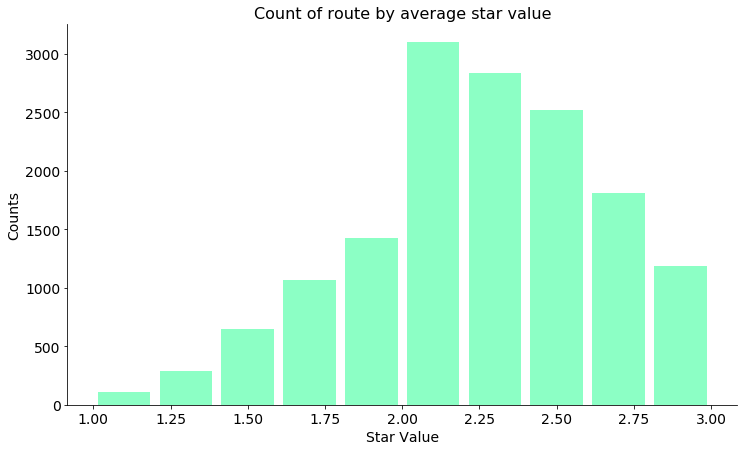

In [12]:
f.hist_avg_star(rock6x, "route", color= "springgreen")

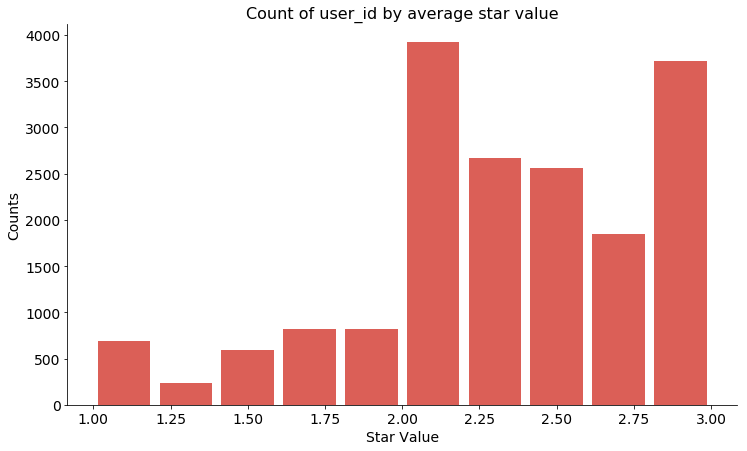

In [13]:
f.hist_avg_star (rock6x, "user_id")

Text(0, 0.5, 'Count')

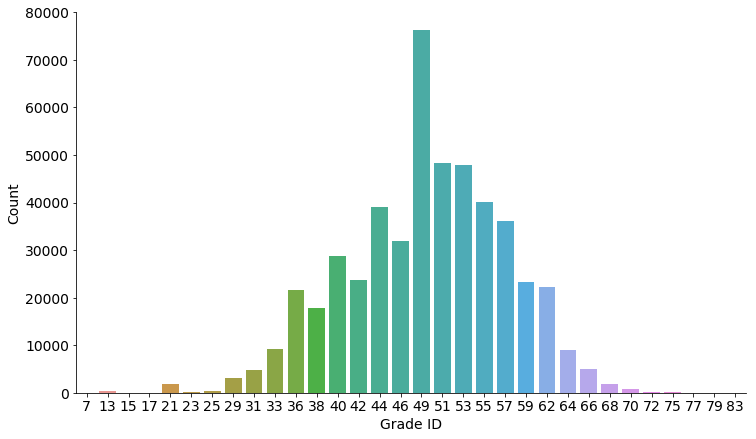

In [15]:
#Most rated grades of climbs (49 or 5.11d is the most popular):

rock_df6.grade_id.value_counts()
#ascent.grade_id.value_counts().plot(kind='barh') #plotting 
rock_df6.grade_id.describe() #seeing summary statistics
sns.countplot(x='grade_id', data=rock_df6) #using seaborn to plot
plt.xlabel("Grade ID")
plt.ylabel("Count")

In [16]:
#Top 20 Routes with the most ratings:

rock6x.route.value_counts(ascending=True)[-20:]

batman          358
excalibur       359
eros            364
aphrodite       364
mandragora      371
serengeti       376
viagraman       383
eclipse         386
harakiri        391
trela           404
duroxmanie      415
lola            416
carnage         428
lapinerie       457
graviton        500
spartacus       500
kastor          525
kerveros        547
gladiator       580
cortomaltese    598
Name: route, dtype: int64

In [17]:
#Top 20 full data 
grouped = rock6x.groupby('route')
grouped.filter(lambda x: x['route'].count() > 400)

,user_id,route,rating,avg_rating,num_users_rate,climb_type,usa_routes,usa_boulders,crag,country
93,206,cortomaltese,2,2.511706,598,Bouldering,5.11d,V6,fontainebleau,FRA
145,272,carnage,3,2.397129,418,Bouldering,5.12c,V8/9,fontainebleau,FRA
163,280,cortomaltese,3,2.511706,598,Bouldering,5.11d,V6,fontainebleau,FRA
164,280,duroxmanie,2,2.730120,415,Bouldering,5.11a,V5,fontainebleau,FRA
166,280,graviton,3,2.310000,500,Bouldering,5.11d,V6,fontainebleau,FRA
187,246,cortomaltese,1,2.511706,598,Bouldering,5.11d,V6,fontainebleau,FRA
191,217,cortomaltese,3,2.511706,598,Bouldering,5.11d,V6,fontainebleau,FRA
192,217,graviton,2,2.310000,500,Bouldering,5.11d,V6,fontainebleau,FRA
209,235,carnage,1,2.397129,418,Bouldering,5.12c,V8/9,fontainebleau,FRA
248,348,graviton,1,2.310000,500,Bouldering,5.11d,V6,fontainebleau,FRA


In [18]:
#Top 20 routes with the highest AVERAGE rate
rock6x_r_means= rock6x.groupby("route", as_index=False)["rating"].mean()
rock6x_r_means.sort_values("rating")[-20:]

,route,rating
5929,iluzija,3.0
10317,poziomki,3.0
11752,seixonoia,3.0
3867,esclatamasters,3.0
2410,cialis,3.0
11011,ribbefett,3.0
5281,guntabaar,3.0
13523,tokolosie,3.0
2669,corisco,3.0
856,assassinos,3.0


In [19]:
#There are 284 routes all have an average of 3-star ratings
rock6x_r_means[rock6x_r_means.rating == 3].count()

route     284
rating    284
dtype: int64

In [20]:
#Top 20 users who gave the most ratings:
rock6x.user_id.value_counts(ascending=True)[-20:]

21355    371
10115    372
20095    374
22828    384
16414    391
26302    392
39559    394
7746     417
11030    423
23956    424
9284     448
7235     507
493      528
13622    535
23550    553
10955    554
4121     558
26155    603
7505     849
5512     920
Name: user_id, dtype: int64

In [21]:
#Top 20 users giving the highest average ratings
rock6x_u_means= rock6x.groupby("user_id", as_index=False)["rating"].mean()
rock6x_u_means.sort_values("rating")[-20:]

,user_id,rating
11052,33706,3.0
11057,33726,3.0
11133,34004,3.0
11130,33991,3.0
11124,33975,3.0
11118,33953,3.0
11117,33948,3.0
11112,33938,3.0
11108,33924,3.0
11140,34034,3.0


In [22]:
#There are 3040 users that provide on average a 3-star ratings
rock6x_u_means[rock6x_u_means.rating == 3].count()

user_id    3040
rating     3040
dtype: int64

/content/function.py:393: RuntimeWarning: divide by zero encountered in log
  df_agg['meanxcount'] = (df_agg['mean'] * np.log(np.log(df_agg['count'])))**2.5


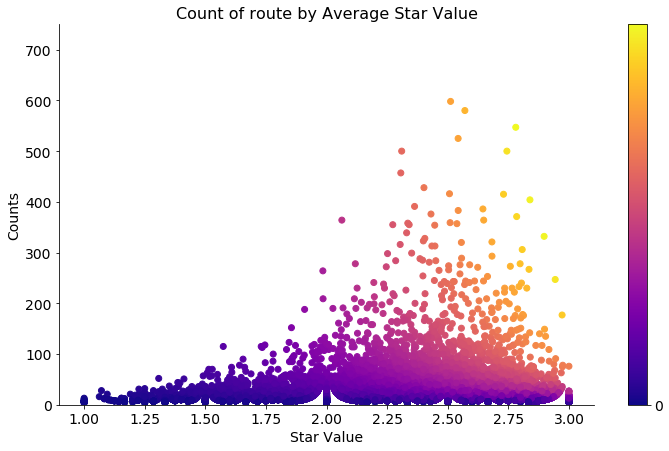

In [23]:
f.count_ratings(rock6x, "route", "plasma")

/content/function.py:393: RuntimeWarning: divide by zero encountered in log
  df_agg['meanxcount'] = (df_agg['mean'] * np.log(np.log(df_agg['count'])))**2.5


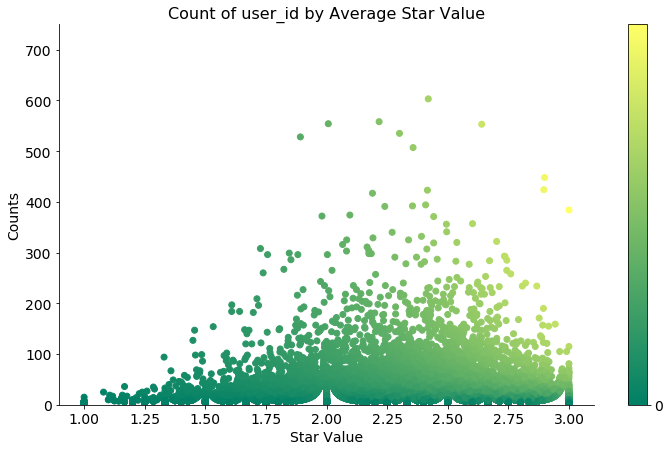

In [24]:
f.count_ratings(rock6x,"user_id", "summer")

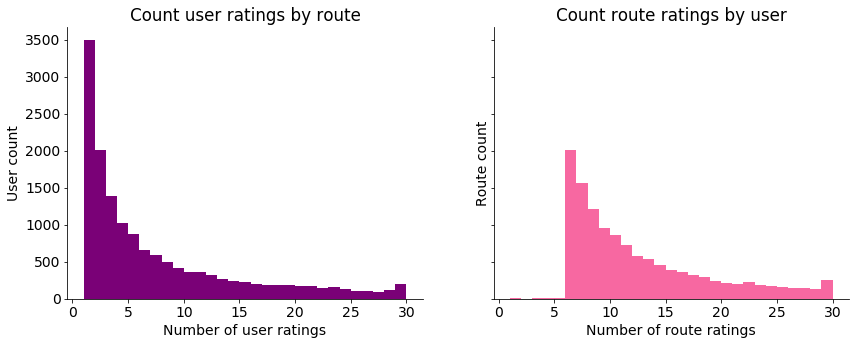

In [25]:
f.plt_count_hists(rock6x)

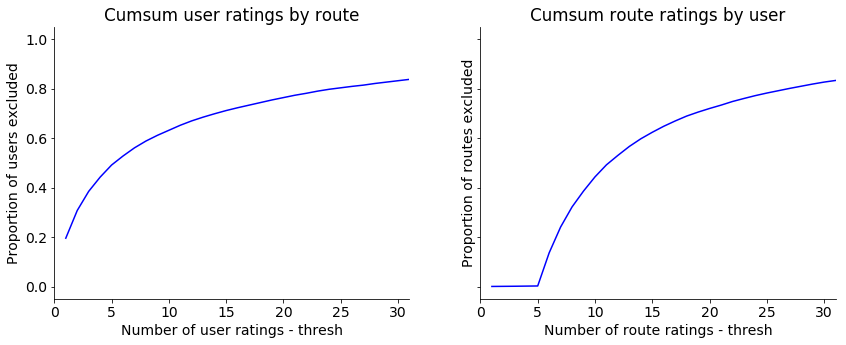

In [26]:
f.plt_cumsum(rock6x)

#RAM, GPU, & Random Sampling

Something that I ran into early on in the machine learning portion of this project, is that I did not have access to enough memory in Google Colab to properly test all the different recommendation algorithms. The solution is to take a random sample of the data.
*   Problem:
  >* If I take a random sample of the entire data set, this will have no way to filter out unique users or routes, and in fact it could be choosing all different routes or users, decreasing their frequency and incresing the sparsity of the matrix. 
* Solution:
>* Create a function that takes into account the unique values of users and routes and then takes a random sample of that. This will allow the smaller sample to reflect the original matrix sparsity
* Note:
>* *Normally, a andom sample would be about 10% of the data frame; however, I increased my percentages because I wanted to make sure I was computing a more accurate recommendation model*

### 1. Demonstration of the problamatic matrix density with a completely random sample
* Below, you can see how the density of the matrix gets worse for all the different data frames when not taking into account unique user & route names

In [0]:
df_sample= rock_df3.sample(frac=0.1, random_state=1)
f.matrix_density(df_sample)

Num of unique routes: 20924
Num of unique users: 12054
Matrix size: 252217896
Shape of df: (55734, 8)
Density of matrix: 0.00022097559643428317


In [0]:
df_sample2= rock_df6.sample(frac=0.1, random_state=1)
f.matrix_density(df_sample2)

Num of unique routes: 15318
Num of unique users: 11417
Matrix size: 174885606
Shape of df: (49344, 8)
Density of matrix: 0.00028215015019589435


In [0]:
df_sample3= rock_df10.sample(frac=0.1, random_state=1)
f.matrix_density(df_sample3)

Num of unique routes: 11128
Num of unique users: 10946
Matrix size: 121807088
Shape of df: (43636, 9)
Density of matrix: 0.00035823859445683487


### 2.Taking a random sample with unique values in mind (best way to keep original matrix density intact):

In [27]:
samp2= f.df_samp_unique_vals(ascent_1x, .25, "user_id", "route")

User drop: 25801
Route drop: 18075
length of entire sample w/ unique users & routes: 4519


/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Num of unique routes: 4519
Num of unique users: 4519
Matrix size: 20421361
Shape of df: (29309, 5)
Density of matrix: 0.001435212863628433


In [28]:
samp3= f.df_samp_unique_vals(rock_df3, .25, "user_id", "route")

User drop: 21647
Route drop: 10919
length of entire sample w/ unique users & routes: 2730
Num of unique routes: 2730
Num of unique users: 2730
Matrix size: 7452900
Shape of df: (13204, 8)
Density of matrix: 0.0017716593540769365


In [30]:
samp6= f.df_samp_unique_vals(rock6x, .65, "user_id", "route") #decided on .65 sample size after testing many different sizes of the 6x DF

User drop: 17878
Route drop: 7195
length of entire sample w/ unique users & routes: 4677
Num of unique routes: 4677
Num of unique users: 4677
Matrix size: 21874329
Shape of df: (47475, 10)
Density of matrix: 0.002170352288291906


In [31]:
samp10= f.df_samp_unique_vals(rock_df10, .4, "user_id", "route")

User drop: 20552
Route drop: 7710
length of entire sample w/ unique users & routes: 3084
Num of unique routes: 3084
Num of unique users: 3084
Matrix size: 9511056
Shape of df: (25371, 9)
Density of matrix: 0.0026675271389423


#Choosing an algorithm:
*Using the four different datasets I will test each of the surprise library algorithms to see which perform the best*
1. Measure:
>$ \operatorname{RMSE}=\sqrt{\frac{\sum_{t=1}^T (\hat y_t - y_t)^2}{T}}\ $
>* **Root mean squared error (RMSE):** 
>>* *Takes the square root of the residual errors of the line of best fit. THUS, if the RMSE is very large that means your residuals are very far away from your line of best fit and this means your model isn't doing well.*
>>* *You want the RMSE to be as **small** as possible and it is a **relative metric** that will change based on the dataset (there is no normal range for RMSE)*
>* I choose this metric over mean absolute error(MAE) because since the errors are squared before they are averaged, the RMSE gives a relatively high weight to large errors. Thus, the RMSE is useful when large errors are particularly undesirable.

2. Results:
>* The lower the RMSE, the better the performance of the prediction
>* There are three top performers amongst the algorithms:
 >> 1. SVD++: This is an evolution of the SVD alogirthm that also takes into account implicit ratings. It is very computational expensive, but is clearly getting the most accurate results with the lowest RMSE
 >>2. SVD: the algorithm popularized by Simon Funk in the Netflix competition. It is performing very well, but is not as computationally expensive as SVD++
 >>3. Baselineonly: a more basic algorithm that uses Alternating Least Squares (ALS) or  Stochastic Gradient Descent (SGD), and has very fast train & test times. It doesn't do much work, and is meant to be a basline comparison to the other algorithms
>* *Interstingly, after performing many different tests, I noticed a trend that the more dense the matrix, the better SVD & SVD++ performed and the less impressive KNN algorithms performed* 

3. **Algorithm Choice:**
 SVD++
 >* Based on the results below, I will attempt to train my model with the SVD++ algorithm, but if I run into memory issues I will default to the SVD algorithm and use gridsearch to fine tune it's parameters
 * SVD will be used to check for signal in my dataset since it is provides a quicker turn around time
 
4. Baseline Algorithms: 
> *algorithms to help judge the performance of our model*
 >* Normal predictor: 
 >>* Assumes the data is normally distributed, and predicts based on the Guassian model.
 >>* the SVD & SVD++ always outperformed the normal predictor (which is an encouraging sign)
 >* Baselineonly: 
 >>* Read description above
 >>* Was able to outperform the SVD algorithm once. Our model needs to be able to beat this basic algorithm. Thus, I will use the SVD++ alogorithm or at least fine tune the parameters for SVD so I can beat the baseline RMSE.
 

In [0]:
#create surprise data objects from the different dataframes

data2= f.read_data_surprise(samp2)
data3= f.read_data_surprise(samp3)
data6= f.read_data_surprise(samp6)
data10= f.read_data_surprise(samp10)

In [0]:
#Algo performance for least filtered route data
#HEAVY... THIS ONE will CRASH DUE TO NOT ENOUGH RAM
# d2= f.algo_tester(data2)
# d2

In [0]:
#Algo performance for 3x route filtered data
d3= f.algo_tester(data3)
d3

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.679606,2.168366,0.087587
SVD,0.683864,0.556795,0.028774
BaselineOnly,0.685080,0.023378,0.024266
KNNBaseline,0.721788,0.145243,0.086453
CoClustering,0.739985,0.431386,0.064119
KNNWithMeans,0.745841,0.144643,0.109090
KNNWithZScore,0.750094,0.205275,0.077314
KNNBasic,0.760350,0.127331,0.073209
SlopeOne,0.771809,0.158347,0.081046


In [33]:
#Algo performance for 6x name filtered data
d6= f.algo_tester(data6)
d6

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.656549,16.115670,0.648576
BaselineOnly,0.660056,0.066147,0.135528
SVD,0.661268,2.013415,0.109702
KNNBaseline,0.697995,0.582456,0.640773
CoClustering,0.705715,1.005888,0.139992
KNNWithMeans,0.707114,0.610985,0.545816
KNNWithZScore,0.707959,0.649346,0.553792
NMF,0.730429,2.461001,0.122456
SlopeOne,0.733207,0.774625,0.367432


In [0]:
#Algo performance for 10x name filtered data
d10= f.algo_tester(data10)
d10

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.669912,6.598286,0.254549
BaselineOnly,0.673458,0.035667,0.079662
SVD,0.675044,1.079167,0.081083
KNNBaseline,0.718186,0.219114,0.234673
CoClustering,0.725839,0.593758,0.047135
KNNWithMeans,0.732549,0.230140,0.201812
KNNWithZScore,0.737102,0.293744,0.246589
NMF,0.756736,1.352768,0.053161
SlopeOne,0.763503,0.272832,0.170774


# Checking for Signal
* Due to RAM constraint, I will use the SVD algorithm to test the dataset for signal (i.e. can my dataset provide good recommendations?)
* I want to make sure that the predictions are accurate and giving the users meaingful recommendations before I proceed with training the model

* **Steps:**
>1. Testing the SVD algorithm for accuracy with the different data sets
>2. Showing the best & worst predictions from the SVD algorithm
>3. Creating a dataframe of all the top ten predictions per user_id

* **Findings:**
>* It can be seen from the violin plots that the more filtered the dataset (look at data10 at the bottom), the more the ratings start to get pushed together & loose some of their useful noise
>* There is a lot of discrepency in the 1 star ratings where there was less data to start with (this is to be expected). Also, the one star ratings are not imperative to this projects goal. It is more important that the 1 star ratings are different enough to be filtered out of the top ten routes recommended to users. 
>* The 2 & 3 star ratings are much more accurate which is good because they will make up the top ten recommendations to the users
>* Reviewing the violin plots below, the 6x dataframe's 3-star rating has a fat bulge at the top of their "violin" which looks like a triangle indicates its predicting 3-star ratings for some of the true 3-star routes. 
>* 6x dataframe also has a fatter tail in the 1-star predictions which means it's also guessing the lower ratings a bit better
>* The top ten "best predictions" are producing some of the listed routes in the "Quick EDA" section. Thus, these recommendations are making sense.

###1. Testing the SVD algorithm for accuracy with the different data sets

RMSE: 0.6626
<class 'pandas.core.series.Series'>
Means of Predicted per True Rating: r_ui
1.0    2.184545
2.0    2.317763
3.0    2.481360
Name: est, dtype: float64
STD of Predicted per True Rating: r_ui
1.0    0.282034
2.0    0.255461
3.0    0.254074
Name: est, dtype: float64


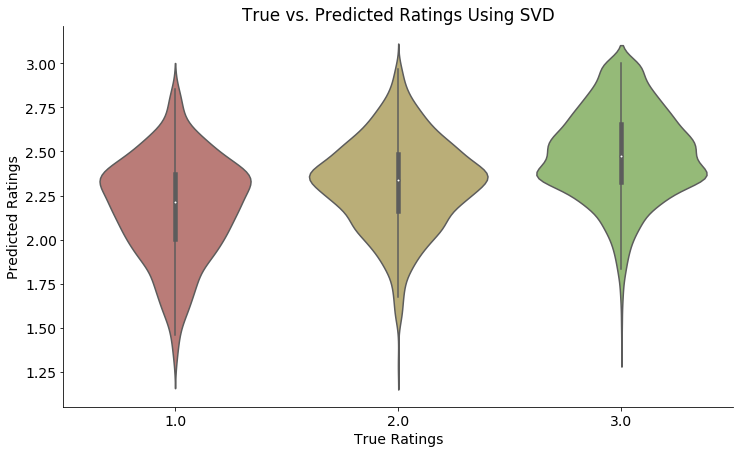

In [0]:
#Least filtered 2x dataset results (filtered out route names occuring less than 2 times)
trainset2, testset2 = train_test_split(data2, test_size=.2)
algo = sp.SVD()
algo.fit(trainset2)
predictions2 = algo.test(testset2)
sp.accuracy.rmse(predictions2)
f.violin_accuracy(algo, testset2)

RMSE: 0.6735
[Prediction(uid=52734, iid='braavos', r_ui=3.0, est=2.3431753841645047, details={'was_impossible': False}), Prediction(uid=21011, iid='aromounos', r_ui=3.0, est=2.494717296406499, details={'was_impossible': False}), Prediction(uid=3763, iid='masken', r_ui=2.0, est=2.318861920141287, details={'was_impossible': False}), Prediction(uid=58526, iid='pepeljuga', r_ui=3.0, est=2.5497639685611992, details={'was_impossible': False}), Prediction(uid=213, iid='supernova', r_ui=3.0, est=2.628721037904297, details={'was_impossible': False}), Prediction(uid=1769, iid='caveman', r_ui=2.0, est=2.517292691629635, details={'was_impossible': False}), Prediction(uid=44025, iid='tuxedomoon', r_ui=2.0, est=2.6287593971598753, details={'was_impossible': False}), Prediction(uid=11979, iid='yanomami', r_ui=3.0, est=2.083801585029611, details={'was_impossible': False}), Prediction(uid=4648, iid='hokej', r_ui=2.0, est=2.92641899693002, details={'was_impossible': False}), Prediction(uid=34528, iid='t

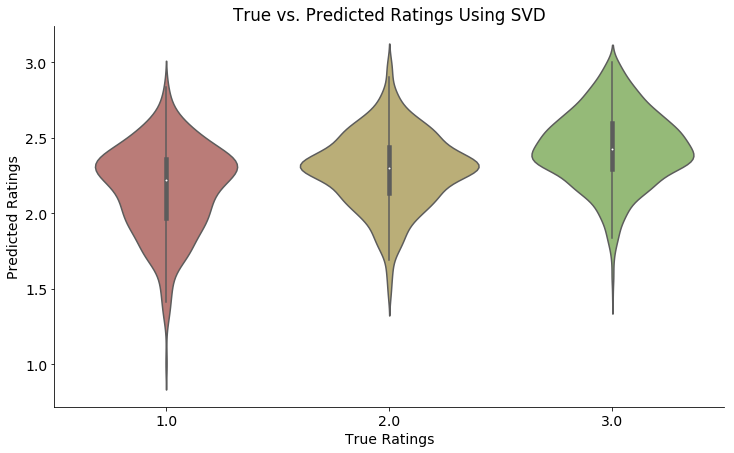

In [0]:
#3x filtered dataset results (filtered out route names occuring less than 3 times)
trainset3, testset3 = train_test_split(data3, test_size=.2)
algo = sp.SVD()
algo.fit(trainset3)
predictions3 = algo.test(testset3)
sp.accuracy.rmse(predictions3)
print (predictions3)
f.violin_accuracy(algo, testset3)

RMSE: 0.6566
<class 'pandas.core.series.Series'>
Means of Predicted per True Rating: r_ui
1.0    2.092802
2.0    2.270809
3.0    2.486992
Name: est, dtype: float64
STD of Predicted per True Rating: r_ui
1.0    0.332413
2.0    0.296451
3.0    0.293939
Name: est, dtype: float64


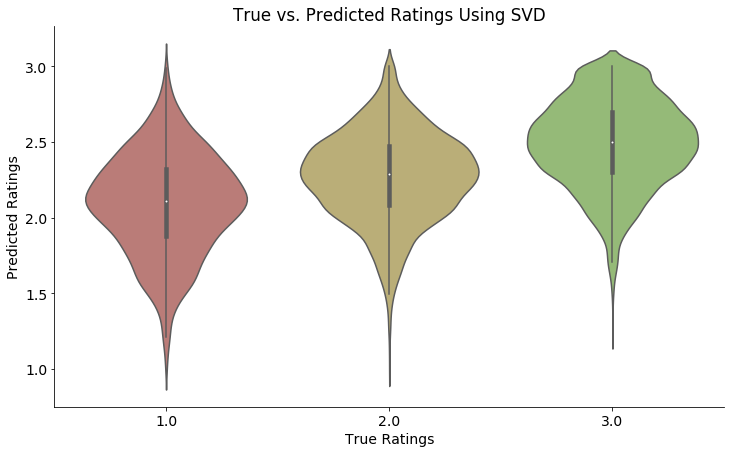

In [34]:
#6x filtered dataset results (filtered out route names occuring less than 6 times)
trainset6, testset6 = train_test_split(data6, test_size=.22)
algo = sp.SVDpp()
algo.fit(trainset6)
predictions6 = algo.test(testset6)
sp.accuracy.rmse(predictions6)
f.violin_accuracy(algo, testset6)

RMSE: 0.6711
<class 'pandas.core.series.Series'>
Means of Predicted per True Rating: r_ui
1.0    2.127542
2.0    2.261433
3.0    2.439387
Name: est, dtype: float64
STD of Predicted per True Rating: r_ui
1.0    0.298774
2.0    0.275430
3.0    0.271748
Name: est, dtype: float64


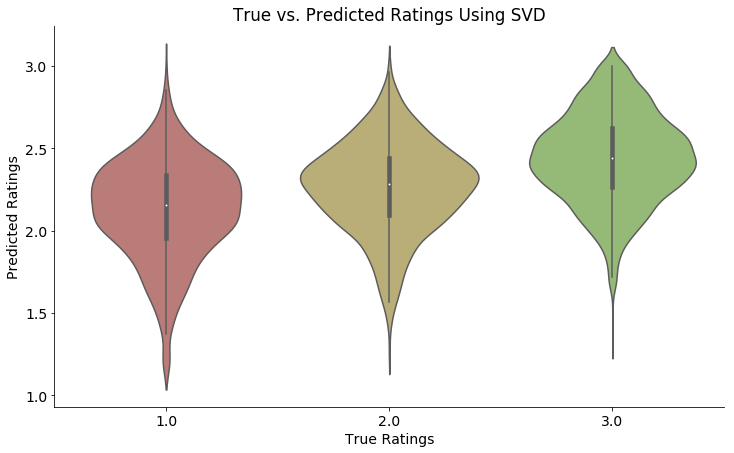

In [0]:
#10x filtered dataset results (filtered out route names occuring less than 10 times)
trainset10, testset10 = train_test_split(data10, test_size=.2)
algo = sp.SVD()
algo.fit(trainset10)
predictions10 = algo.test(testset10)
sp.accuracy.rmse(predictions10)
f.violin_accuracy(algo, testset10)

### 2. Showing the best & worst predictions from the SVD algorithm with the four different datasets

In [0]:
#Prediction results for 2x filtered dataset (filtered out route names occuring less than 2 times)
predict_df2 = f.get_predict_df(predictions2)

In [0]:
#Prediction results for 3x filtered dataset (filtered out route names occuring less than 3 times)
predict_df3 = f.get_predict_df(predictions3)

In [0]:
#Prediction results for 6x filtered dataset (filtered out route names occuring less than 6 times)
predict_df6 = f.get_predict_df(predictions6)

Best Predictions:
        uid           iid  rui  est                    details  err
161   20561      escamoso  3.0  3.0  {'was_impossible': False}  0.0
456   22390     rebellion  3.0  3.0  {'was_impossible': False}  0.0
3579  48080      sandokan  3.0  3.0  {'was_impossible': False}  0.0
2175  51580    manuchakra  3.0  3.0  {'was_impossible': False}  0.0
1311  22828         venus  3.0  3.0  {'was_impossible': False}  0.0
5696  18518        panico  3.0  3.0  {'was_impossible': False}  0.0
3699    654      coliseum  3.0  3.0  {'was_impossible': False}  0.0
218   51580          eden  3.0  3.0  {'was_impossible': False}  0.0
1170   7939    enterprise  3.0  3.0  {'was_impossible': False}  0.0
4976  42197  magnetfinger  3.0  3.0  {'was_impossible': False}  0.0
Worst Predictions:
        uid        iid  rui       est                    details       err
5114    118    golgota  1.0  2.792537  {'was_impossible': False}  1.792537
351   31301     sahara  1.0  2.802413  {'was_impossible': False} 

In [0]:
#Prediction results for 10x filtered dataset (filtered out route names occuring less than 10 times)
predict_df10 = f.get_predict_df(predictions10)

#Fine Tuning Filters & Parameters

**1.Choosing a Dataset:**
>*Out of the four filtered dataframes, which should I choose to train my model on?*
>* **6x route name filter datset**
>>* Based on the matrix density, shape, & the RMSE of the predictions, I will be using the datset that filters out any route name that occurs less than 6 times. This filter performed the best in all tests conducted.*italicized text*
>>* When evaluating the violin plots the 6x dataset performed the most accurate predictions in the 1, 2, & 3 star range
>>>* The 10x filter was close, but seemed to be too filtered and all the averages of the predictions to the actual ratings were starting to get compressed together
>>* This dataset seemed to perform the best all around, and will help the spelling issue from my cleaning report

**2.Cold Start Problem:** 

* What is it?
>Collaborative based recommendation systems have a weakness with new or under rated users/items. The recommendation system looses performance based on how many recommendations the user/item has at the time. The collaborative filter has a particularly challenging time recommending routes to brand new users who haven't rated anything. 

* Solution:
> * Create a cold-start threshold wherein any user under that threshold will be given an average top ten recommendation until they rate enough routes that the recommendation system can provide an accurate prediction (same for the routes/items coldstart threshold except the route will be left out of any recommendations till it recieves enough ratings)
> * There is a trade off that needs to be considered: **how much of my data will be lost when I increase the coldstart threshold?**
>>* Using a RMSE/survivorship graph, I will be able to see the trade off between a better RMSE and the survivorship of the users/routes based on every coldstart threshold from 0-20. This graph and surviorship idea was borrowed from Colin Brochard in this [notebook](https://github.com/sailskisurf23/MtProj/tree/master/5_analysis)
> * This notebook did not have enough memory to run these tests, so I created a separate [Cold Start Threshold notebook](https://colab.research.google.com/drive/1b4ZIY5v_POjfQm7vGPUvopoDJE4IOdcP). I ran about 10 different tests with different dataframes, coldstarts, & algorithms, but recieved the best results from the 6x filter dataframe and the SVD algorithm with 20 interations. The findings from this notebook are detailed below.

* Route (item) threshold:
>* Below is a demonstration that increasing the route coldstart threshold to 12 will loose about 50% of the routes to increase the RMSE by only .005. This is not a good enough improvement to justify loosing half of the route data.
>* Thus, the chosen 6x route name dataset will serve as my coldstart threshold for the route names. All routes with less than 6 occurances will not be included in the recommendation system.
>![route-thresh](https://drive.google.com/uc?id=16Ec5xvY-ck94adqFEIHYza7P_rrYqYdC)

* User threshold:
>* Increasing the user threshold to 5 would increase the RMSE by .005 & would loose approximately 40% of the data.
>* Increasing the user threshold to 13 would increase the RMSE by .0075 & would loose approximately 60% of the data
>* If there were a larger increase in the RMSE (>= .01) I would trade my users data for this improvement. However, these improvements are too minuscule to give up 40%-60% of my data to train on. Instead, I will keep some of these outliers to help the model train, and will focus on fine tuning my parameters using gridsearch to improve the RMSE
>* Also, the SVD algorithm tends to do well with predictions of users with less information than other recommendation algorithms
>> ![user-threshold](https://drive.google.com/uc?id=1N1wgTwOl4s_WKEoFrbEdql7dySoTRr4Y)


**3. Fine Tuning Algorithm Parameters using GridSearch**

Parameters:
>* **n_epochs**: (default=20) How many times to perform stochastic gradient descent (SGD) steps 
>>>![minimization](https://drive.google.com/uc?id=1Y_rR-RQIop5QAn2NtyWjP0xTNxk7RAU-)
* **lr_all:** (default=.005) This parameter indicates the learning rate and will determine how fast or slow SGD will move towards the optimal weights. If the learning rate is too large it will miss the optimal solution. If it is too small it will need too many iterations to converge to the best values. So using a good learning rate is crucial.
* **reg_all:** (default=0.02) It is the regularization rate of all parameters. This helps the model generalize well and not over-fit the training set since it introduces a penalty term to our minimization equation. Simon Funk found the best regularization rate for his [Netflix algorithm](https://sifter.org/~simon/journal/20061211.html) to be .02
>![alt text](https://drive.google.com/uc?id=1ccJszFzQGor_kCjlZuyQjs0kx5LnqKu2)
* **init_mean:**(default= 0) The inital mean is based on a normal distribution and set to 0, but I will test it with the average of the ratings of the 6x filtered dataset (2.3396)

Parameters Trials:
>* Below is a comprehensive list of all the different combinations that were trialed on the "samp6" dataframe:
>>> ![parameters](https://drive.google.com/uc?id=1kTO7bYA0Nun_DYXadpQQcg4IOKctgBfP)

Results:

>* The best performing parameters on the SVD++ algorithm are:

>>> **{'n_epochs': 18, lr_all': 0.01, 'reg_all': 0.175}  = 0.65503 RMSE**


In [0]:
#Specific parameters to test

param_grid = {  'n_epochs'  : [16,18,20], 
                'lr_all'    : [.01, .015],
                'reg_all'   :  [.175,.185]}
            #'init_std_dev'  : [.1, 0.72556],
                #'init_mean' : [0, 2.3396]}

algorithm = sp.SVDpp

In [36]:
f.grid_search(data6, param_grid, algorithm)

0.6533729386757622
{'n_epochs': 18, 'lr_all': 0.01, 'reg_all': 0.175}


In [37]:
f.grid_search(data6, param_grid, algorithm)

0.6546022816181751
{'n_epochs': 22, 'lr_all': 0.01, 'reg_all': 0.16}


#Conclusions
* Choose the 6x route name filtered dataset for the best accuracy in recommendations
* Created a sampling technique that took into account unique values to keep the integrity of the matrix density (which is very important to collaborative recommendation systems)
* The recommendations produced were matching up with the some of the top routes found in the "Quick EDA" section. Thus, the recommendations didn't jsut have a good RMSE, they also made logical sense.
* Decided not increase the route or user coldstart threshold due to the survivorship tradeoffs with only minor improvements to the RMSE
* Choose the SVD++ alogirthm that takes implicit ratings into account. This algorithm proved the most successful after ever test
* Fine tuned the SVD++ parameters for a slight improvement in the RMSE ({'n_epochs': 18, 'lr_all': 0.01, 'reg_all': 0.175})

# Creating the Prediction Model


* Due to RAM constraints on google colab, I had to train a 65% sample of the original 6x dataset. Without resource limittions, I would love to train on the full dataset in the future. Prelimnary tests showed that the bigger the training size, the lower the RMSE. One test showed an increase in sample size could increase the RMSE by .03 (in constrast to the .005 improvement I received when increasing the coldstart threshold)

* I used this [notebook](https://colab.research.google.com/drive/1-Ml604746if6IxYaTxrnikVM8v99o2RM) to train, test, and predict on my 6x dataset. 

* This [predictions notebook](https://colab.research.google.com/drive/1vLkoW_4SYessy_igmJxlVz_jEPlgJ06v) is the final product where the user can enter their user_id number and get the top ten rock climbing route recommendations
>* In the future, I would love to spend more time creating a filtering system, wherein a climber could filter out the type, difficulty of climb, & country before receiving their recommendation
>* This could also be improved by connecting to the 8a.nu website so that the user could input their actual ID instead of just their user_id number